In [10]:
import imageio.v3
import glob
import numpy as np
from natsort import natsorted
import os
import cv2
import matplotlib.pyplot as plt
import scipy
import csv

In [31]:
def resize_images(images_path, output_folder):

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # sortiert Ordnernamen aufsteigend
    images_numbers = sorted(os.listdir(images_path), key=lambda x: int(x))


    for folder in natsorted(os.listdir(images_path)):

        for file in os.listdir(os.path.join(images_path, folder)):
            output_ff = os.path.join(folder, file)
            image_path = os.path.join(images_path, output_ff)

            # liest Bild ein
            image = cv2.imread(image_path)

            # Ändere die Größe des Bildes auf ... Pixel
            resized_image = cv2.resize(image, (50,50))

            # Konvertiere das Bild in Graustufen
            gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

            # Speichere das neue Bild im Ausgabeordner mit dem gleichen Dateinamen
            output_path = os.path.join(output_folder, output_ff)
            cv2.imwrite(output_path, gray_image)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26']


resize train und test data from resize_images

In [ ]:
output_folder = 'resized_images/test/'
images_path = "../02_data_crop/test/"

resize_images(images_path, output_folder)

In [17]:
def get_own_dataset (images_path):
    own_dataset = []
    
    for folder in natsorted(os.listdir(images_path)): # for folder in train
        # Label wird definiert
        label = int(folder)   # 1,2,3,4 ...
        print(label)

        for file in os.listdir(os.path.join(images_path, folder)): # for file in train/1
            path = os.path.join(images_path, folder, file)

            # load image data from png files into an array
            img_array = imageio.v3.imread(path, mode='F')
            
            # reshape from 28x28 to list of 784 values, invert values
            img_data  = 255.0 - img_array.reshape(2500)

            # then scale data to range from 0.01 to 1.0
            img_data = (img_data / 255.0 * 0.99) + 0.01

            # append label and image data  to test data set
            record = np.append(label,img_data)

            # create own dataset
            own_dataset.append(record)
    return own_dataset


schreibe test und train dataset als arrays

In [18]:
images_path = './resized_images/train/'
own_dataset = get_own_dataset(images_path=images_path)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


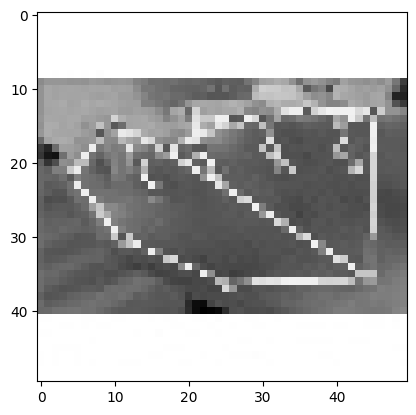

In [19]:
plt.imshow(own_dataset[0][1:].reshape(50,50), cmap='Greys', interpolation='None')

In [20]:
print(own_dataset[420])

[2.   0.01 0.01 ... 0.01 0.01 0.01]


In [21]:
import csv
with open('own_mnist_train.csv', mode='w', newline='') as file:
    writer = csv.writer(file)

    # Schreibe die Daten für jedes Bild
    for i, image in enumerate(own_dataset):
        data = image.flatten()
        writer.writerow(data)

In [22]:
class Cnn:

    # initialise the cnn
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # set number of nodes in each inut, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        #link weight matrices
        self.wih = np.random.normal(0.0, pow(self.hnodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))

        # learning rate
        self.lr = learningrate
        
        # sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)
        pass

    # train the cnn
    def train(self, inputs_list, targets_list):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T

        # calculate signals into hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)

        # calculate signals into final output layer
        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)

        # output layer error is target - actual
        output_errors = targets - final_outputs
        hidden_errors = np.dot(self.who.T, output_errors)

        # update the weights for the links between hidden and output layers
        # update the weights for the links between the input and hidden layers
        self.who += self.lr * np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
        self.wih = self.lr * np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))

        pass

    # query the cnn
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T

        # calculate signals into hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        # calculate zhe signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)

        # calculate signals into final output layer
        final_inputs = np.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)

        return final_outputs
        


In [31]:
input_nodes = 2500
hidden_nodes = 200
output_nodes = 27

learning_rate = 0.3

n = Cnn(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [29]:
training_data_file = open('own_mnist_train.csv')
training_data_list = training_data_file.readlines()
training_data_file.close()

In [32]:
# train the neural network

# epochs is the number of times the training data set is used for training
epochs = 5
for e in range (epochs):
    for record in training_data_list:
        all_values = record.split(',')
        inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        targets = np.zeros(output_nodes) + 0.01
        targets[int(float(all_values[0]))] = 0.99
        n.train(inputs, targets)
        pass
    pass

In [33]:
test_data_file = open('own_mnist_test.csv')
test_data_list = test_data_file.readlines()
test_data_file.close()

test_all_values = test_data_list[0].split(',')
print(test_all_values[0])

1.0


In [35]:
scorecard = []
for record in test_data_list:
    all_values = record.split(',')
    correct_label = int(float(all_values[0]))

    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    outputs = n.query(inputs)

    label = np.argmax(outputs)

    if (label == correct_label):
        scorecard.append(1)
    else:
        scorecard.append(0)
        pass
    pass

In [36]:
scorecard_array = np.asarray(scorecard)
print("performance = ", scorecard_array.sum() / scorecard_array.size)

performance =  0.03863134657836645
